In [1]:
def zigzag(df, threshold=0.10, column='close', pct=True):
    """
    Calculate Zig-Zag points (swing highs/lows) on OHLC data.

    Args:
        df (pd.DataFrame): DataFrame with columns ['open', 'high', 'low', 'close']. Index should be datetime or string.
        threshold (float): The minimum change to recognize a new high/low. If pct=True, this is treated as percentage (e.g., 0.05 means 5%).
        column (str): The price column to use for calculation. Usually 'close', but can be 'high', 'low', etc.
        pct (bool): If True, threshold is treated as percentage; else, as absolute price difference.

    Returns:
        pd.DataFrame: Original df with two new columns: 'zigzag' (values at swing points, else NaN), and 'zigzag_type' (1 for high, -1 for low, NaN otherwise).
    """
    df = df.copy()
    prices = df[column].values
    indices = df.index

    # Initialize results
    zigzag = [None] * len(df)
    zigzag_type = [None] * len(df)

    # Initial state: find high after low
    last_pivot_idx = 0
    last_pivot_price = prices[0]
    searching_for = 'high'  # alternate between 'high'/'low'

    # Mark first point as a pivot (could be high or low, doesn't matter yet)
    zigzag[0] = prices[0]
    zigzag_type[0] = -1  # Assume starting from a low
    temp_pivot_idx = 0
    temp_pivot_price = prices[0]

    for i in range(1, len(prices)):
        price = prices[i]

        if searching_for == 'high':
            lastSearch = 'high'
            # Update temp_pivot if new high found
            if price > temp_pivot_price:
                temp_pivot_price = price
                temp_pivot_idx = i

            # Calculate drop from temp_pivot_price
            drop = (temp_pivot_price - price) / temp_pivot_price if pct else (temp_pivot_price - price)
            if drop >= threshold:
                # Confirm high
                zigzag[temp_pivot_idx] = temp_pivot_price
                zigzag_type[temp_pivot_idx] = 1
                last_pivot_idx = temp_pivot_idx
                last_pivot_price = temp_pivot_price
                # Switch to searching for low
                searching_for = 'low'
                temp_pivot_idx = i
                temp_pivot_price = price
                lastSearch = 'high'

        elif searching_for == 'low':
            lastSearch = 'low'
            # Update temp_pivot if new low found
            if price < temp_pivot_price:
                temp_pivot_price = price
                temp_pivot_idx = i

            # 價格自低位回升的幅度
            rise = (price - temp_pivot_price) / temp_pivot_price if pct else (price - temp_pivot_price)
            if rise >= threshold:
                # Confirm low
                zigzag[temp_pivot_idx] = temp_pivot_price
                zigzag_type[temp_pivot_idx] = -1
                last_pivot_idx = temp_pivot_idx
                last_pivot_price = temp_pivot_price
                # Switch to searching for high
                searching_for = 'high'
                temp_pivot_idx = i
                temp_pivot_price = price
                lastSearch = 'low'

        # recorde the searchingFor and the drop
        df.loc[indices[i], 'prev_searching_for'] = lastSearch
        df.loc[indices[i], 'searching_for'] = searching_for

        try:
            # print(drop if searching_for == 'high' else rise)
            df.loc[indices[i], '反彈或回落'] = drop if lastSearch == 'high' else rise
        except Exception as e:
            continue
    
    # Optionally, mark the last temp_pivot as a point (it might not be a confirmed swing yet)
    zigzag[temp_pivot_idx] = temp_pivot_price
    zigzag_type[temp_pivot_idx] = 1 if searching_for == 'high' else -1

    df['zigzag'] = zigzag
    df['zigzag_type'] = zigzag_type
    return df


def findPivotSignal(zz, testCcy, holdDay):
    import numpy as np
    import pandas as pd

    confirmed_high = []
    confirmed_high_date = []
    confirmed_low = []
    confirmed_low_date = []

    last_confirmed_high = np.nan
    last_confirmed_high_date = pd.NaT
    last_confirmed_low = np.nan
    last_confirmed_low_date = pd.NaT

    for i, row in enumerate(zz.itertuples()):
        # --- 找上一段 searching_for == 'low' 的區間 ---
        if getattr(row, 'searching_for') == 'high' and getattr(row, 'prev_searching_for') == 'low':
            start_idx = None
            # 反向找最近一次不是low的地方
            for j in range(i-1, -1, -1):
                if zz.iloc[j]['searching_for'] != 'low':
                    start_idx = j + 1
                    break
            if start_idx is None:
                start_idx = 0
            period = zz.iloc[start_idx:i]
            if not period.empty:
                min_row = period[testCcy].idxmin()
                last_confirmed_low = zz.loc[min_row, testCcy]
                last_confirmed_low_date = row.Index

        # --- 找上一段 searching_for == 'high' 的區間 ---
        if getattr(row, 'searching_for') == 'low' and getattr(row, 'prev_searching_for') == 'high':
            start_idx = None
            for j in range(i-1, -1, -1):
                if zz.iloc[j]['searching_for'] != 'high':
                    start_idx = j + 1
                    break
            if start_idx is None:
                start_idx = 0
            period = zz.iloc[start_idx:i]
            if not period.empty:
                max_row = period[testCcy].idxmax()
                last_confirmed_high = zz.loc[max_row, testCcy]
                last_confirmed_high_date = row.Index

        confirmed_high.append(last_confirmed_high)
        confirmed_high_date.append(last_confirmed_high_date)
        confirmed_low.append(last_confirmed_low)
        confirmed_low_date.append(last_confirmed_low_date)

    zz['confirmed_high'] = confirmed_high
    zz['confirmed_high_date'] = confirmed_high_date
    zz['confirmed_low'] = confirmed_low
    zz['confirmed_low_date'] = confirmed_low_date


    import pandas as pd
    import numpy as np
    from pandas.tseries.offsets import BDay

    # --- Step 1: Suppress signal if confirmed_high <= confirmed_low ---
    price_col = testCcy
    zz['signal'] = 0

    for i, row in zz.iterrows():
        if pd.notnull(row['confirmed_high']) and pd.notnull(row['confirmed_low']) and row['confirmed_high'] <= row['confirmed_low']:
            zz.at[row.name, 'signal'] = 0
        elif pd.notnull(row['confirmed_high']) and row[price_col] >= row['confirmed_high'] and row['confirmed_high_date'] < row.name:
            zz.at[row.name, 'signal'] = 1
        elif pd.notnull(row['confirmed_low']) and row[price_col] <= row['confirmed_low'] and row['confirmed_low_date'] < row.name:
            zz.at[row.name, 'signal'] = -1
        # else remains 0

    # --- Step 2: Simulate position holding, NO mandatory waiting period after closing ---
    zz['position'] = 0
    current_pos = 0
    entry_date = None
    last_signal_type = 0

    for i, row in enumerate(zz.itertuples()):
        idx = row.Index
        signal = row.signal
        current_date = idx  # assumes index is datetime

        if current_pos == 0:
            if signal != 0:
                current_pos = signal
                entry_date = current_date
                zz.at[idx, 'position'] = current_pos
                last_signal_type = signal
            else:
                zz.at[idx, 'position'] = 0
        else:
            zz.at[idx, 'position'] = current_pos
            if signal == -current_pos and signal != 0:
                current_pos = 0
                entry_date = None
                zz.at[idx, 'position'] = 0
                last_signal_type = signal
            elif entry_date is not None and current_date >= (entry_date + BDay(holdDay)):
                current_pos = 0
                entry_date = None
                zz.at[idx, 'position'] = 0
    return zz


In [2]:
# def findPivotSignal(zz, testCcy, holdDay):
#     import numpy as np
#     import pandas as pd

#     confirmed_high = []
#     confirmed_high_date = []
#     confirmed_low = []
#     confirmed_low_date = []

#     last_confirmed_high = np.nan
#     last_confirmed_high_date = pd.NaT
#     last_confirmed_low = np.nan
#     last_confirmed_low_date = pd.NaT

#     for i, row in enumerate(zz.itertuples()):
#         # --- 找上一段 searching_for == 'low' 的區間 ---
#         if getattr(row, 'searching_for') == 'high' and getattr(row, 'prev_searching_for') == 'low':
#             start_idx = None
#             # 反向找最近一次不是low的地方
#             for j in range(i-1, -1, -1):
#                 if zz.iloc[j]['searching_for'] != 'low':
#                     start_idx = j + 1
#                     break
#             if start_idx is None:
#                 start_idx = 0
#             period = zz.iloc[start_idx:i]
#             if not period.empty:
#                 min_row = period[testCcy].idxmin()
#                 last_confirmed_low = zz.loc[min_row, testCcy]
#                 last_confirmed_low_date = row.Index

#         # --- 找上一段 searching_for == 'high' 的區間 ---
#         if getattr(row, 'searching_for') == 'low' and getattr(row, 'prev_searching_for') == 'high':
#             start_idx = None
#             for j in range(i-1, -1, -1):
#                 if zz.iloc[j]['searching_for'] != 'high':
#                     start_idx = j + 1
#                     break
#             if start_idx is None:
#                 start_idx = 0
#             period = zz.iloc[start_idx:i]
#             if not period.empty:
#                 max_row = period[testCcy].idxmax()
#                 last_confirmed_high = zz.loc[max_row, testCcy]
#                 last_confirmed_high_date = row.Index

#         confirmed_high.append(last_confirmed_high)
#         confirmed_high_date.append(last_confirmed_high_date)
#         confirmed_low.append(last_confirmed_low)
#         confirmed_low_date.append(last_confirmed_low_date)

#     zz['confirmed_high'] = confirmed_high
#     zz['confirmed_high_date'] = confirmed_high_date
#     zz['confirmed_low'] = confirmed_low
#     zz['confirmed_low_date'] = confirmed_low_date


#     import pandas as pd
#     import numpy as np
#     from pandas.tseries.offsets import BDay

#     # --- Step 1: Suppress signal if confirmed_high <= confirmed_low ---
#     zz['dir_position'] = 0
#     zz['rev_position'] = 0

#     # --- Directional Position Logic (hold for 2 days) ---
#     current_pos = 0
#     entry_date = None
#     holdDay = 2
#     for i, row in enumerate(zz.itertuples()):
#         idx = row.Index
#         signal = row.signal
#         current_date = idx

#         if current_pos == 0:
#             if signal != 0:
#                 current_pos = signal
#                 entry_date = current_date
#                 zz.at[idx, 'dir_position'] = current_pos
#             else:
#                 zz.at[idx, 'dir_position'] = 0
#         else:
#             zz.at[idx, 'dir_position'] = current_pos
#             if entry_date is not None and current_date > (entry_date + pd.offsets.BDay(holdDay - 1)):
#                 current_pos = 0
#                 entry_date = None
#                 zz.at[idx, 'dir_position'] = 0

#     # --- Reversal Position Logic (hold for 1 day) ---
#     current_pos = 0
#     entry_date = None
#     holdDay = 1
#     for i, row in enumerate(zz.itertuples()):
#         idx = row.Index
#         signal = row.rev_signal
#         current_date = idx

#         if current_pos == 0:
#             if signal != 0:
#                 current_pos = signal
#                 entry_date = current_date
#                 zz.at[idx, 'rev_position'] = current_pos
#             else:
#                 zz.at[idx, 'rev_position'] = 0
#         else:
#             zz.at[idx, 'rev_position'] = current_pos
#             if entry_date is not None and current_date > (entry_date + pd.offsets.BDay(holdDay - 1)):
#                 current_pos = 0
#                 entry_date = None
#                 zz.at[idx, 'rev_position'] = 0

#     # If you want the net combined position:
#     zz['net_position'] = zz['dir_position'] + zz['rev_position']

#     return zz

In [3]:
import pandas as pd
from pandas.tseries.offsets import BDay

def open_after_signal(zz, holdDay=1):
    """
    zz: DataFrame with at least ['signal'] column and datetime index.
    holdDay: int, number of business days to hold the position after entering.

    Returns:
        zz: DataFrame with new column 'position_delayed', which opens the position
            one business day after the signal and holds for `holdDay` days.
    """
    zz = zz.copy()
    zz['position_delayed'] = 0
    open_dates = []
    close_dates = []
    positions = []

    for i, row in zz.iterrows():
        if row['signal'] == 0:
            continue
        # Open position on next business day
        entry_date = i + BDay(1)
        exit_date = entry_date + BDay(holdDay)
        # Find index locations for entry/exit
        mask = (zz.index >= entry_date) & (zz.index <= exit_date)
        zz.loc[mask, 'position_delayed'] = row['signal']
    
    return zz

In [4]:
# import numpy as np
# import pandas as pd
# from datetime import datetime, timedelta

# # --- Only import modules once at the top ---
# import sys
# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def optimize_fx_sharpe(
#     holdDays, testCcys, startDate='2012-01-01', endDate='2022-12-31', threshold=1.5*0.01
# ):
#     results = []
#     for testCcy in testCcys:
#         info = myTrade.init(startDate, endDate, [testCcy])
#         # info.setBasket([testCcy])
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()
#         for holdDay in holdDays:
#             print(f"Testing ccy = {testCcy}, holdDay = {holdDay}")
#             try:
#                 zz = zigzag(spot, threshold=threshold, column=testCcy, pct=True)
#                 zz = findPivotSignal(zz, testCcy, holdDay)
#                 zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#                 zz['position_shifted'] = zz['position'].shift(1).fillna(0)
#                 zz['strategy_log_ret'] = zz['position_shifted'] * zz['log_ret']
#                 zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()
#                 zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#                 equity_df = zz[['equity_curve', 'strategy_log_ret', 'position', testCcy]].rename(
#                     columns={'strategy_log_ret': 'daily_equity_curve'}
#                 )
#                 btRes = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, endDate)
#                 sharpe = btRes.loc['回測期間', 'yearlySharpe']
#                 ret = btRes.loc['回測期間', 'return(%)']
#             except Exception as e:
#                 print(f"Error for {testCcy}-{holdDay}: {e}")
#                 sharpe, ret = np.nan, np.nan
#             results.append({'ccy': testCcy, 'holdDay': holdDay, 'sharpe': sharpe, 'ret': ret})
#     # Combine into a single DataFrame for easy analysis
#     results_df = pd.DataFrame(results)
#     return results_df

# # Example usage
# # holdDays = [1, 2, 3, 4, 5, 10, 11, 12, 13, 14]
# holdDays = [1, 2, 3, 4, 5, 10]
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'CHF', 'ZAR', 'SEK']
# results_df = optimize_fx_sharpe(holdDays, testCcys)
# print(results_df)
# # To get best by Sharpe:
# best_result = results_df.loc[results_df['sharpe'].idxmax()]
# print("Best Sharpe:", best_result)

# ## visaulize the results please 
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Suppose your results_df is already loaded as shown in your example
# # If not, you can create it with pd.read_csv or from_dict

# # Ensure 'holdDay' is numeric for plotting
# results_df['holdDay'] = pd.to_numeric(results_df['holdDay'])

# # Set up the plotting style
# sns.set(style="whitegrid")

# # 1. Sharpe Ratio vs Hold Day for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='holdDay', y='sharpe', hue='ccy', marker='o')
# plt.title('Sharpe Ratio by Hold Day for each Currency')
# plt.xlabel('Hold Days')
# plt.ylabel('Sharpe Ratio')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 2. Return vs Hold Day for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='holdDay', y='ret', hue='ccy', marker='o')
# plt.title('Return (%) by Hold Day for each Currency')
# plt.xlabel('Hold Days')
# plt.ylabel('Return (%)')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 3. If you want subplots for each currency:
# g = sns.FacetGrid(results_df, col='ccy', col_wrap=3, height=4, sharey=False)
# g.map_dataframe(sns.lineplot, x='holdDay', y='sharpe', marker='o')
# g.set_axis_labels('Hold Days', 'Sharpe Ratio')
# g.set_titles('Sharpe for {col_name}')
# plt.tight_layout()
# plt.show()





In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Example threshold list
# thresholds = [0.5*0.01, 1.0*0.01, 1.5*0.01, 2.0*0.01, 2.5*0.01]
# holdDay = 2  # Fix hold day
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'CHF', 'ZAR', 'SEK']
# results = []

# for threshold in thresholds:
#     for testCcy in testCcys:
#         # ... (run your logic, e.g. optimize_fx_sharpe for one threshold & ccy)
#         # Replace with your actual logic
#         try:
#             info = myTrade.init('2012-01-01', '2022-12-31', [testCcy])
#             spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#             ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#             for ccy in ohlc:
#                 ohlc[ccy] = ohlc[ccy].shift(1).dropna()
#             zz = zigzag(spot, threshold=threshold, column=testCcy, pct=True)
#             zz = findPivotSignal(zz, testCcy, holdDay)

#             # zz = open_after_signal(zz, holdDay=holdDay) 


#             zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#             zz['position_shifted'] = zz['position'].shift(1).fillna(0)
#             zz['strategy_log_ret'] = zz['position_shifted'] * zz['log_ret']
#             zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()
#             zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#             equity_df = zz[['equity_curve', 'strategy_log_ret', 'position', testCcy]].rename(
#                 columns={'strategy_log_ret': 'daily_equity_curve'}
#             )
#             btRes = my.getDetailedTradingStats(equity_df['daily_equity_curve'], '2012-01-01', '2022-12-31')
#             sharpe = btRes.loc['回測期間', 'yearlySharpe']
#             ret = btRes.loc['回測期間', 'return(%)']
#         except Exception as e:
#             print(f"Error for {testCcy}-{threshold}: {e}")
#             sharpe, ret = np.nan, np.nan
#         results.append({'ccy': testCcy, 'threshold': threshold, 'sharpe': sharpe, 'ret': ret})

# results_df = pd.DataFrame(results)
# results_df['threshold'] = pd.to_numeric(results_df['threshold'])

# # --- Plotting ---

# sns.set(style="whitegrid")

# # 1. Sharpe Ratio vs Threshold for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='threshold', y='sharpe', hue='ccy', marker='o')
# # add a horiziontail line on y=0
# plt.axhline(0, color='red', linestyle='--', linewidth=1)
# plt.title(f'Sharpe Ratio by Threshold (Hold Days = {holdDay})')
# plt.xlabel('Threshold')
# plt.ylabel('Sharpe Ratio')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 2. Return vs Threshold for each currency
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=results_df, x='threshold', y='ret', hue='ccy', marker='o')
# plt.axhline(0, color='red', linestyle='--', linewidth=1)
# plt.title(f'Return (%) by Threshold (Hold Days = {holdDay})')
# plt.xlabel('Threshold')
# plt.ylabel('Return (%)')
# plt.legend(title='Currency')
# plt.tight_layout()
# plt.show()

# # 3. Subplots for each currency
# g = sns.FacetGrid(results_df, col='ccy', col_wrap=3, height=4, sharey=False)
# g.map_dataframe(sns.lineplot, x='threshold', y='sharpe', marker='o')
# g.set_axis_labels('Threshold', 'Sharpe Ratio')
# g.set_titles('Sharpe for {col_name}')
# plt.tight_layout()
# plt.show()

In [6]:
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
#     equity_curves = []
#     zz_dict = {}
#     zz_full = {}

#     for testCcy in testCcys:
#         # info = myTrade.init(startDate, endDate)
#         # info.setBasket([testCcy])

#         # just for 9/6
#         info = myTrade.init(startDate, endDate, [testCcy])
        
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()

#         # Always run zigzag first!
#         zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

#         # Reverse leg: holdDay=1, reverse signal
#         zz_rev = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
#         rev_signal = -1 * zz_rev['position'].fillna(0)

#         # Direction leg: holdDay=2, same signal
#         zz_dir = findPivotSignal(zz_base.copy(), testCcy, holdDay=2)
#         dir_signal = zz_dir['position'].fillna(0)

#         zz_dir_day2 = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
#         dir_signal_day2 = zz_dir_day2['position'].shift(1).fillna(0)

#         # Use the same index for all signals and returns
#         zz = zz_base.copy()
#         zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))

#         # orginal code
#         # zz['rev_signal'] = rev_signal
#         # zz['dir_signal'] = dir_signal
#         # zz['composite_position'] = 0.5 * zz['rev_signal'] + 0.5 * zz['dir_signal']

       
#         zz['dir_signal'] = dir_signal_day2
#         zz['composite_position'] = 1 * zz['dir_signal']

#         # Strategy returns (shift to enter at today's close, earn tomorrow's return)
#         zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
#         zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

#         zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#         zz['daily_equity_curve'] = zz['strategy_log_ret']

#         equity_curves.append(zz['equity_curve'].rename(testCcy))
#         zz_dict[testCcy] = zz.copy()
#         zz_full[testCcy] = zz_dir.copy()

#     # Equally weight all currencies
#     equity_df = pd.concat(equity_curves, axis=1).dropna()
#     equity_df['mean_equity'] = equity_df.mean(axis=1)
#     # add daily returns for mean_equity
#     equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)

#     return equity_df, zz_dict, zz_full



# # Example usage:
# startDate = '2012-01-01'
# # endDate = '2022-12-31'
# endDate = '2025-04-30'
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD']
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'ZAR']
# # testCcys = ['GBP']

# equity_df, zz_dict, zz_full = get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.5*0.01)
# equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
# plt.xlabel('Date')
# plt.ylabel('Equity')
# plt.show()




# #import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']  # add fonts in order of preference
# plt.rcParams['axes.unicode_minus'] = False  # fix for minus sign


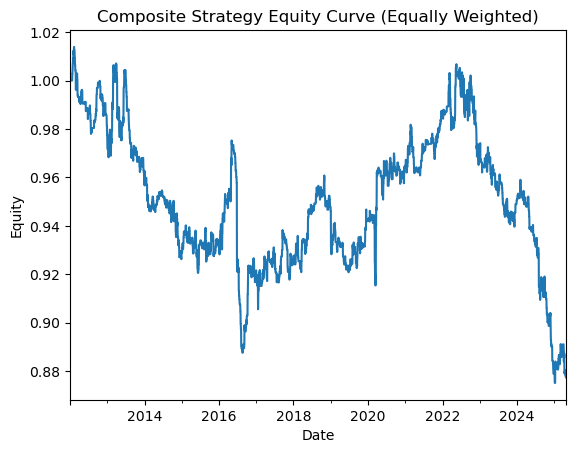

In [7]:
# only for GBP and jPY
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
import my, myTrade, myOption

def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
    equity_curves = []
    zz_dict = {}
    zz_full = {}

    for testCcy in testCcys:
        # info = myTrade.init(startDate, endDate)
        # info.setBasket([testCcy])

        # just for 9/6
        info = myTrade.init(startDate, endDate, [testCcy])
        
        spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
        ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
        for ccy in ohlc:
            ohlc[ccy] = ohlc[ccy].shift(1).dropna()

        # Always run zigzag first!
        zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

        # Reverse leg: holdDay=1, reverse signal
        zz_dir_day1 = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
        dir_signal_day1 = -1 * zz_dir_day1['position'].fillna(0)


        zz_dir_day2 = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
        dir_signal_day2 = zz_dir_day2['position'].shift(1).fillna(0)

        # Use the same index for all signals and returns
        zz = zz_base.copy()
        zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))

        # orginal code
        # zz['rev_signal'] = rev_signal
        # zz['dir_signal'] = dir_signal
        # zz['composite_position'] = 0.5 * zz['rev_signal'] + 0.5 * zz['dir_signal']

        if testCcy == 'GBP':
            zz['dir_signal'] = dir_signal_day2
        if testCcy == 'JPY':
            zz['dir_signal'] = dir_signal_day1
        zz['composite_position'] = 1 * zz['dir_signal']

        # Strategy returns (shift to enter at today's close, earn tomorrow's return)
        zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
        zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

        zz['equity_curve'] = np.exp(zz['cum_log_ret'])
        zz['daily_equity_curve'] = zz['strategy_log_ret']

        equity_curves.append(zz['equity_curve'].rename(testCcy))
        zz_dict[testCcy] = zz.copy()
        zz_full[testCcy] = zz_dir_day1.copy()

    # Equally weight all currencies
    equity_df = pd.concat(equity_curves, axis=1).dropna()
    equity_df['mean_equity'] = equity_df.mean(axis=1)
    # add daily returns for mean_equity
    equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)

    return equity_df, zz_dict, zz_full



# Example usage:
startDate = '2012-01-01'
# endDate = '2022-12-31'
endDate = '2025-04-30'
testCcys = ['EUR', 'GBP', 'AUD', 'NZD']
testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'ZAR']
testCcys = ['GBP', 'JPY']
# testCcys = ['GBP']

equity_df, zz_dict, zz_full = get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.5*0.01)
equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.show()




#import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']  # add fonts in order of preference
plt.rcParams['axes.unicode_minus'] = False  # fix for minus sign


In [8]:
aa = zz_dict['EUR']
aa

KeyError: 'EUR'

In [ ]:
bb = zz_full['EUR']
bb

,EUR,prev_searching_for,searching_for,反彈或回落,zigzag,zigzag_type,confirmed_high,confirmed_high_date,confirmed_low,confirmed_low_date,signal,position
2012-01-02,1.2939,NaN,NaN,NaN,1.2939,-1.0,NaN,NaT,NaN,NaT,0,0
2012-01-03,1.2989,high,high,0.000000,NaN,NaN,NaN,NaT,NaN,NaT,0,0
2012-01-04,1.3041,high,high,0.000000,1.3041,1.0,NaN,NaT,NaN,NaT,0,0
2012-01-05,1.2934,high,low,0.008205,NaN,NaN,1.3041,2012-01-05,NaN,NaT,0,0
2012-01-06,1.2777,low,low,0.000000,NaN,NaN,1.3041,2012-01-05,NaN,NaT,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-24,1.1380,low,low,0.000000,NaN,NaN,1.1556,2025-04-23,1.0924,2025-04-09,0,0
2025-04-25,1.1360,low,low,0.000000,NaN,NaN,1.1556,2025-04-23,1.0924,2025-04-09,0,0
2025-04-28,1.1348,low,low,0.000000,1.1348,-1.0,1.1556,2025-04-23,1.0924,2025-04-09,0,0
2025-04-29,1.1404,low,low,0.004935,NaN,NaN,1.1556,2025-04-23,1.0924,2025-04-09,0,0


In [ ]:
# # only jpy and gbp
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
#     equity_curves = []
#     zz_dict = {}

#     for testCcy in testCcys:
#         # info = myTrade.init(startDate, endDate)
#         # info.setBasket([testCcy])

#         # just for 9/6
#         info = myTrade.init(startDate, endDate, [testCcy])
        
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()

#         # Always run zigzag first!
#         zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

#         # Reverse leg: holdDay=1, reverse signal
#         zz_rev = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
#         rev_signal = -1 * zz_rev['position'].fillna(0)

#         # Direction leg: holdDay=2, same signal
#         zz_dir = findPivotSignal(zz_base.copy(), testCcy, holdDay=2)
#         dir_signal = zz_dir['position'].fillna(0)

#         # Use the same index for all signals and returns
#         zz = zz_base.copy()
#         zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#         zz['rev_signal'] = rev_signal
#         zz['dir_signal'] = dir_signal

#         zz['composite_position'] = 0.5 * zz['rev_signal'] + 0.5 * zz['dir_signal']

#         # Strategy returns (shift to enter at today's close, earn tomorrow's return)
#         zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
#         zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

#         zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#         zz['daily_equity_curve'] = zz['strategy_log_ret']

#         equity_curves.append(zz['equity_curve'].rename(testCcy))
#         zz_dict[testCcy] = zz.copy()

#     # Equally weight all currencies
#     equity_df = pd.concat(equity_curves, axis=1).dropna()
#     equity_df['mean_equity'] = equity_df.mean(axis=1)
#     # add daily returns for mean_equity
#     equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)

#     return equity_df, zz_dict

# # Example usage:
# startDate = '2012-01-01'
# # endDate = '2022-12-31'
# endDate = '2025-04-30'
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD']
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'SEK', 'ZAR', 'CHF']

# equity_df, zz_dict = get_composite_equity_curve(startDate, endDate, testCcys, threshold=1.5*0.01)
# equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
# plt.xlabel('Date')
# plt.ylabel('Equity')
# plt.show()




# #import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']  # add fonts in order of preference
# plt.rcParams['axes.unicode_minus'] = False  # fix for minus sign


In [ ]:
# # hold on day 2 version
# import sys
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# sys.path.append(rf'C:\Users\Blair Lin\quantTrade_2025\utils')
# import my, myTrade, myOption

# def get_composite_equity_curve(startDate, endDate, testCcys, threshold=0.01):
#     equity_curves = []
#     zz_dict = {}
#     zz_full = {}

#     for testCcy in testCcys:
#         # info = myTrade.init(startDate, endDate)
#         # info.setBasket([testCcy])

#         # just for 9/6
#         info = myTrade.init(startDate, endDate, [testCcy])
        
#         spot = my.getCMTKSpot(info.tradeBasket, info.startDate, info.endDate)
#         ohlc = my.getOHLC_BGN(info.tradeBasket, info.startDate, info.endDate)
#         for ccy in ohlc:
#             ohlc[ccy] = ohlc[ccy].shift(1).dropna()

#         # Always run zigzag first!
#         zz_base = zigzag(spot, threshold=threshold, column=testCcy, pct=True)

#         # Find the pivot signals, holdDay=1 so signal is only on the first day after the pivot
#         zz_dir = findPivotSignal(zz_base.copy(), testCcy, holdDay=1)
#         # Shift the signal forward by 1 business day to act only on the 2nd day after the pivot
#         dir_signal = zz_dir['position'].shift(1).fillna(0)

#         # Use the same index for all signals and returns
#         zz = zz_base.copy()
#         zz['log_ret'] = np.log(zz[testCcy] / zz[testCcy].shift(1))
#         zz['dir_signal'] = dir_signal

#         zz['composite_position'] = zz['dir_signal']

#         # Strategy returns (shift to enter at today's close, earn tomorrow's return)
#         zz['strategy_log_ret'] = zz['composite_position'].shift(1).fillna(0) * zz['log_ret']
#         zz['cum_log_ret'] = zz['strategy_log_ret'].cumsum()

#         zz['equity_curve'] = np.exp(zz['cum_log_ret'])
#         zz['daily_equity_curve'] = zz['strategy_log_ret']

#         equity_curves.append(zz['equity_curve'].rename(testCcy))
#         zz_dict[testCcy] = zz.copy()
#         zz_full[testCcy] = zz_dir.copy()

#     # Equally weight all currencies
#     equity_df = pd.concat(equity_curves, axis=1).dropna()
#     equity_df['mean_equity'] = equity_df.mean(axis=1)
#     # add daily returns for mean_equity
#     equity_df['daily_equity_curve'] = equity_df['mean_equity'].pct_change().fillna(0)


#     return equity_df, zz_dict, zz_full

# # Example usage:
# startDate = '2012-01-01'
# # endDate = '2022-12-31'
# endDate = '2025-04-30'
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD']
# testCcys = ['EUR', 'GBP', 'AUD', 'NZD', 'JPY', 'CAD', 'SEK', 'ZAR', 'CHF']

# equity_df, zz_dict, zz_full = get_composite_equity_curve(startDate, endDate, testCcys, threshold=1*0.01)
# equity_df['mean_equity'].plot(title='Composite Strategy Equity Curve (Equally Weighted)')
# plt.xlabel('Date')
# plt.ylabel('Equity')
# plt.show()




# #import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS', 'Noto Sans CJK SC']  # add fonts in order of preference
# plt.rcParams['axes.unicode_minus'] = False  # fix for minus sign


In [ ]:
test = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, '2022-12-31')
test

,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe,yearlyProfit(pos=USD1mio),dailyStd(pos=USD1mio)
2012,-0.48,0.19,3.52,-0.151,"-4,800","1,900"
2013,-1.00,0.17,2.34,-0.369,"-10,000","1,700"
2014,0.07,0.15,2.77,0.027,700,"1,500"
2015,3.88,0.22,1.82,1.095,"38,800","2,200"
2016,1.22,0.24,4.51,0.310,"12,200","2,400"
2017,0.79,0.18,1.39,0.267,"7,900","1,800"
2018,2.08,0.20,3.09,0.649,"20,800","2,000"
2019,-3.89,0.16,5.08,-1.514,"-38,900","1,600"
2020,10.02,0.30,1.97,1.993,"100,200","3,000"
2021,-0.84,0.19,3.84,-0.273,"-8,400","1,900"


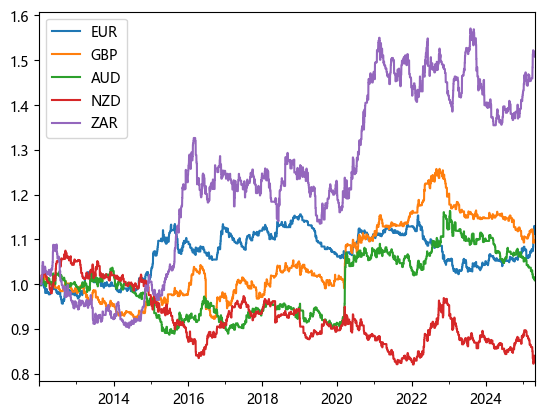

In [ ]:
for ccy in testCcys:
    equity_df[ccy].plot(label=ccy)
    plt.legend()

In [ ]:
test.loc['回測期間', 'yearlySharpe']

0.39

In [ ]:
test_full = my.getDetailedTradingStats(equity_df['daily_equity_curve'], startDate, endDate)

In [ ]:
test_full

,return(%),dailyStd(%),yearlyMDD(%),yearlySharpe,yearlyProfit(pos=USD1mio),dailyStd(pos=USD1mio)
2012,-0.48,0.19,3.52,-0.151,"-4,800","1,900"
2013,-1.00,0.17,2.34,-0.369,"-10,000","1,700"
2014,0.07,0.15,2.77,0.027,700,"1,500"
2015,3.88,0.22,1.82,1.095,"38,800","2,200"
2016,1.22,0.24,4.51,0.310,"12,200","2,400"
2017,0.79,0.18,1.39,0.267,"7,900","1,800"
2018,2.08,0.20,3.09,0.649,"20,800","2,000"
2019,-3.89,0.16,5.08,-1.514,"-38,900","1,600"
2020,10.02,0.30,1.97,1.993,"100,200","3,000"
2021,-0.84,0.19,3.84,-0.273,"-8,400","1,900"


In [ ]:
test_full.loc['回測期間', 'yearlySharpe']

0.258